In [1]:
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import random
from numpy.random import multivariate_normal
%matplotlib inline

def Question1and3(sim, n):
    sum1,sq_sum1,mini,maxi = reduce(lambda x,y : (x[0]+y,x[1]+y**2,min(x[2],y),max(x[3],y)),\
                                        sim.sample_repeated(n),(0,0,999999,-999999))
    print("The mean is {}".format(sum1/n))
    print("The std_dev is {}".format(math.sqrt(sq_sum1/n - (sum1/n)**2)))
    print("The min is {}".format(mini))
    print("The max is {}".format(maxi))
def Question4(sim,boolean_func, n):
    sum1 = reduce(lambda x,y :x + int(y), sim.sample_boolean_repeated(boolean_func,n),0)
    print("The probability is {}".format(sum1/n))

nextpos = 0
reward_array = None
deviation_array = None
episodes_array = None
standard_dev = 0

class MDP():
    termial_absorbing_state = "inf"
    
    def __init__(self, states, actions, transition_function, reward_function, initial_state_func, damping_constant, policy):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function
        self.reward_function = reward_function
        self.initial_state_func = initial_state_func
        self.damping_constant = damping_constant
        self.policy = policy
        
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0

        
    def run_step(self):
        action = self.policy(self.current_state,actions)
        new_state = self.transition_function(self.current_state,action)
        self.current_reward += self.reward_function(new_state,action)*self.damping_constant**(self.timestep)
        self.timestep +=1
        self.current_state = new_state
    
    def run_mdp(self):
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0
        
        while self.current_state != self.termial_absorbing_state:
            self.run_step()
        return self.current_reward
    
    def sample_repeated(self,n):
        i = n
        while (i>0):
            i-=1
            X = self.run_mdp()
            global standard_dev
            standard_dev += X**2
            yield X

            
    def check_boolean(self,boolean_func):
        self.current_state = self.initial_state_func()
        self.timestep = 0
        
        while self.current_state != self.termial_absorbing_state:
            self.run_step()            
            boolean = boolean_func(self)
            if boolean is None:
                pass
            else:
                return boolean
        return False
    def sample_boolean_repeated(self,boolean_func,n):
        i = n
        while (i>0):
            i-=1
            yield self.check_boolean(boolean_func)
            
def policy_paramaterized(param,sigma,state,actions):
    X = param[state-1]
    norm = np.exp(X * sigma)
    norm /= np.sum(norm)
    return np.random.choice(actions, p=norm)

#.05,no_itterations,1,run_mdp
def CrossEntropyPolicySearch(no_dim,mean_policy,covariance,no_policies,top_e,\
                             no_episodes,no_itterations,epsilon,sigma,MDP):
    assert ( no_policies >= top_e)

    global reward_array
    reward_array = np.zeros(no_itterations)
    global deviation_array ; global standard_dev    
    deviation_array = np.zeros(no_itterations)
    global episodes_array
    episodes_array = np.zeros(no_itterations)

    #reward_array = np.zeros((no_episodes*no_policies*no_itterations),dtype=np.float64)
    global nextpos
    nextpos = 0
    avgRew = 0
    i = 0    
    while i < no_itterations:
        i+=1
        J = []
        k = 0
        params = multivariate_normal(mean_policy,covariance,[no_policies])        
        standard_dev = 0
        for p in params:
            MDP.policy = lambda st,acts: policy_paramaterized(p.reshape(22,4),sigma,st,acts)
            J.append((p,sum(MDP.sample_repeated(no_episodes))/no_episodes))
        J.sort(key = lambda x : x[1], reverse = True)
        top_policy,rewards = zip(*J)
        avgRew = sum(rewards)/len(rewards)
        standard_dev = standard_dev/(no_policies*no_episodes) - avgRew
        top_policy = top_policy[0:top_e]
        mean_policy = np.average(top_policy,axis = 0)
        centered_policy = map(lambda x : x - mean_policy,top_policy)
        covar_policy = map(lambda x : np.outer(x,x),centered_policy)
        covariance = (epsilon*np.eye(no_dim)+sum(covar_policy))/(epsilon+top_e)
        #print("itteration#{} with average reward : {}".format(i,avgRew))
        #print('')
        reward_array[nextpos] = avgRew
        deviation_array[nextpos] = math.sqrt(standard_dev+epsilon)
        episodes_array[nextpos] = no_episodes*i*no_policies 
        nextpos += 1
def HillClimbingPolicySearch(no_dim,mean_policy,covariance,\
                             no_episodes,no_itterations,sigma,MDP):
    global reward_array
    reward_array = []
    global deviation_array
    deviation_array = []
    global episodes_array
    episodes_array = []

    global standard_dev
    standard_dev = 0    
    avgRew = 0
    mean_J = 0
    prev_iter = 0
    MDP.policy = lambda st,acts: policy_paramaterized(mean_policy.reshape(22,4),sigma,st,acts)    
    J = sum(MDP.sample_repeated(no_episodes))/no_episodes
    i = 0
    while i < no_itterations:
        i+=1
        param = multivariate_normal(mean_policy,covariance)
        MDP.policy = lambda st,acts: policy_paramaterized(param.reshape(22,4),sigma,st,acts)
        new_J = sum(MDP.sample_repeated(no_episodes))/no_episodes
        mean_J +=new_J
        if new_J > J:
            #print(i)
            J = new_J
            mean_policy = param
            standard_dev = (standard_dev/no_episodes - mean_J)/(i-prev_iter)
            mean_J  = 0
            prev_iter = i
            reward_array.append(new_J)
            deviation_array.append(math.sqrt(standard_dev))
            episodes_array.append(no_episodes*i)
            standard_dev = 0

        #print("itteration#{} with average reward : {}".format(i,avgRew))
        #print('')
        
    

states = list(range(1,23))
states.append('inf')
actions = ["AU","AD","AL","AR"]
action_dict= {"AU":[.8,0,.05,.05,.1],
              "AL":[.05,.05,.8,0,.1],
              "AR":[.05,.05,0,.8,.1],
              "AD":[0,.8,.05,.05,.1]}
                #   U D L R C
transition_dict = {1:[0,5,0,1,0],
                   2:[0,5,-1,1,0],
                   3:[0,5,-1,1,0],
                   4:[0,5,-1,1,0],
                   5:[0,5,-1,0,0],
                   6:[-5,5,0,1,0],
                   7:[-5,5,-1,1,0],
                   8:[-5,0,-1,1,0],
                   9:[-5,4,-1,1,0],
                  10:[-5,4,-1,0,0],
                  11:[-5,4,0,1,0],
                  12:[-5,4,-1,0,0],
                  13:[-4,4,0,1,0],
                  14:[-4,4,-1,0,0],
                  15:[-4,4,0,1,0],
                  16:[-4,4,-1,0,0],
                  17:[-4,5,0,1,0],
                  18:[-4,None,-1,0,0],
                  19:[-4,0,0,1,0],
                  20:[-4,0,-1,1,0],
                  21:[0,0,-1,1,0],
                  22:[-5,0,-1,None,0]}
def policy_random(state,actions):
    return random.choice(actions)    

def transition_func(state,action):
    direction = np.random.choice(list(range(5)),p = action_dict[action])
    change = transition_dict[state][direction]
    if change is None:
        return 'inf'
    else:
        return state + change
def reward_func(state,action):
    if state ==21:
        return -10
    elif state == 'inf':
        return 10
    else:
        return 0
# Definition of policy for Question 2
position_action_dict = {1:"AR",
               2:"AR",
               3:"AR",
               4:"AR", ####
               5:"AD",
               6:"AR",
               7:"AR",
               8:"AR",
               9:"AD", ####
              10:"AD",
              11:"AU",
              12:"AU",
              13:"AD",
              14:"AD",
              15:"AU",
              16:"AU",
              17:"AD",#####
              18:"AD",
              19:"AU",
              20:"AU",
              21:"AR",
              22:"AR"}
                #   U D L R
def policy_optimal(state,actions):
    return position_action_dict[state]

def boolean_Question4(my_mdp):
    if my_mdp.timestep == 11:
        return (my_mdp.current_state == 21)
    else:
        return None
    

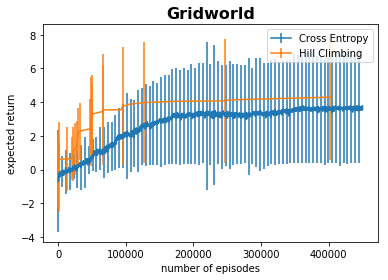

In [3]:
# Answer to Question 1
no_dims = (len(states)-1)*len(actions)
sigma = 1

myMDP = MDP(states,actions,transition_func,reward_func,lambda  : 1, .9, None)
no_samples= 15 #N
no_policies = 15 #K
top_examples = 3
no_itterations = 2000 #no_itterations
sigma = .4 # Determinism parameter for SoftMax
epsilon = .04 # Numeric Stability parameter for Cross Entropy
omega = .75 # Sigma for HillClimbing Covariance matrix

CrossEntropyPolicySearch(no_dims,np.random.random_sample((no_dims,)),np.eye(no_dims),\
                         no_policies,top_examples,no_samples,no_itterations,epsilon,sigma,myMDP)
#plt.plot(range(no_itterations),reward_array)
plt.errorbar(episodes_array,reward_array,deviation_array,label = 'Cross Entropy',errorevery =25)
                         
HillClimbingPolicySearch(no_dims,np.random.random_sample((no_dims,)),np.eye(no_dims)*omega,\
                             no_samples,no_policies*no_itterations,sigma,myMDP)
plt.errorbar(episodes_array,reward_array,deviation_array,label = "Hill Climbing",errorevery = 2)
plt.legend()
plt.title("Gridworld", fontsize=16, fontweight='bold')
plt.ylabel("expected return")
plt.xlabel("number of episodes")
plt.show()


In [9]:
# Answer to Question 1
random_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 1, .9, policy_random)
Question1and3(random_policyMDP,10000)

TypeError: 'NoneType' object does not support item assignment

In [10]:
# Answer to Question 3
optimal_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 1, .9, policy_optimal)
Question1and3(optimal_policyMDP,10000)


TypeError: 'NoneType' object does not support item assignment

In [52]:
# Answer to Question 4
random_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 18, .9, policy_random)
Question4(random_policyMDP,boolean_Question4,100000)

The probability is 0.01872


In [36]:
for x in multivariate_normal([1,1,1,2],[[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]],[5]):
    y = x.reshape((4,1))
    #print(x)
    #print(y[1])
    print(x)
    print(x.T)
    print(np.outer(x,x))
    print()


[0.05142238 0.05142238 0.05142238 1.05142238]
[0.05142238 0.05142238 0.05142238 1.05142238]
[[0.00264426 0.00264426 0.00264426 0.05406664]
 [0.00264426 0.00264426 0.00264426 0.05406664]
 [0.00264426 0.00264426 0.00264426 0.05406664]
 [0.05406664 0.05406664 0.05406664 1.10548902]]

[0.2453605  0.24536052 0.24536052 1.24536052]
[0.2453605  0.24536052 0.24536052 1.24536052]
[[0.06020177 0.06020178 0.06020178 0.30556228]
 [0.06020178 0.06020178 0.06020178 0.3055623 ]
 [0.06020178 0.06020178 0.06020178 0.3055623 ]
 [0.30556228 0.3055623  0.3055623  1.55092282]]

[2.43563036 2.43563036 2.43563036 3.43563036]
[2.43563036 2.43563036 2.43563036 3.43563036]
[[ 5.93229527  5.93229526  5.93229526  8.36792562]
 [ 5.93229526  5.93229525  5.93229525  8.36792561]
 [ 5.93229526  5.93229525  5.93229525  8.36792561]
 [ 8.36792562  8.36792561  8.36792561 11.80355598]]

[0.98831223 0.98831225 0.98831225 1.98831225]
[0.98831223 0.98831225 0.98831225 1.98831225]
[[0.97676107 0.97676108 0.97676108 1.96507332]

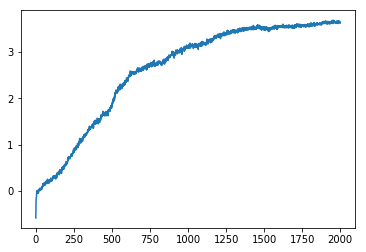

In [7]:
plt.plot(range(no_itterations),reward_array)


In [1]:
x= 1
print (x)

1
